# Erzeugung des aktuellen MSG-Bildes als Hintergrundbild

Das Hintergrundbild besteht aus einer Kombination aus NC-Komposit und IR-10,8-µm-Darstellung.

In [83]:
import datetime as dt
import load_satellite_data as lsd
import glob
import pandas as pd
import numpy as np

import MSGtools as mst
from plotting_tools.colormaps import enhanced_colormap2
emap = enhanced_colormap2()

import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
%matplotlib inline

import PIL

import astro
import h5py

Zuerst müssen wir den letzten verfügbaren Zeitschritt finden. Dazu bestimmen wir die aktuelle Zeit. Da die Verarbetiugn und Übertragung der Daten vom Satelliten nach Darmstadt und dann wieder zu uns ein wenig dauert suchen wir uns am besten die Datei mit dem letzten Zeitstempel heraus.

In [ ]:
pzs_path = "/vols/altair/datasets/eumcst/msevi_pzs/l15_hrit/"
rss_path = "/vols/altair/datasets/eumcst/msevi_rss/l15_hrit/"

In [2]:
now = dt.datetime.now()

In [74]:
def find_latest_msg_time_slot(scan_type='pzs'):
    valid_scan_types = ['rss','pzs']
    
    if scan_type in valid_scan_types:
        msg_data_dir = "/vols/altair/datasets/eumcst/msevi_{}/l15_hrit".format(scan_type)

        now = dt.datetime.now()

        file_dir = "{}/{}/{:02d}/{:02d}/".format(msg_data_dir,now.year,now.month,now.day)

        available_files = glob.glob("{}*.tar".format(file_dir))
        latest_file = sorted(available_files)[-1] 
        latest_time_slot = latest_file.split("/")[-1].split(".")[0].split("-")[2]
               
        return pd.Timestamp(latest_time_slot[:-1],tz='UTC').to_pydatetime()
    else:
        print("{} is not a valid scan type identifier. Only 'pzs' and 'rss' are valid.")
        return

In [ ]:
scan_type = 'pzs'

In [98]:
latest_time_slot = find_latest_msg_time_slot(scan_type)
print latest_time_slot

2019-02-27 13:15:00+00:00


OK, das funktioniert. Jetzt müssen wir uns nur die entsprechenden Kanäle laden. Für das NC-Komposit brauchen wir die Kanäle VIS 6,0 µm, VIS 8,0 µm und NIR 1,6 µm. Zusätzlich brauchen wir noch IR 10,8 µm für den Bereich, in dem Nacht herrscht.

In [99]:
channels = ['VIS006','VIS008','IR_016','IR_108']

In [100]:
sat_data = lsd.load_satellite_data_multichannel(latest_time_slot,
                                                channels,
                                                region='full',
                                                scan_type=scan_type)

... reading  /tmp/hrit6262310109/H-000-MSG4__-MSG4________-VIS008___-000001___-201902271315-__
... reading  /tmp/hrit6262310109/H-000-MSG4__-MSG4________-VIS008___-000002___-201902271315-__
... reading  /tmp/hrit6262310109/H-000-MSG4__-MSG4________-VIS008___-000003___-201902271315-__
... reading  /tmp/hrit6262310109/H-000-MSG4__-MSG4________-VIS008___-000004___-201902271315-__
... reading  /tmp/hrit6262310109/H-000-MSG4__-MSG4________-VIS008___-000005___-201902271315-__
... reading  /tmp/hrit6262310109/H-000-MSG4__-MSG4________-VIS008___-000006___-201902271315-__
... reading  /tmp/hrit6262310109/H-000-MSG4__-MSG4________-VIS008___-000007___-201902271315-__
... reading  /tmp/hrit6262310109/H-000-MSG4__-MSG4________-VIS008___-000008___-201902271315-__
... reading  /tmp/hrit6262310109/H-000-MSG4__-MSG4________-IR_108___-000001___-201902271315-__
... reading  /tmp/hrit6262310109/H-000-MSG4__-MSG4________-IR_108___-000002___-201902271315-__
... reading  /tmp/hrit6262310109/H-000-MSG4__-MSG4

In [88]:
def array_to_256(array):
    return (array*255.999).astype("uint8")

def day_natural_composite(vis006_data,vis008_data,nir016_data,factor=1,gamma=1):
    blue = array_to_256(np.clip(vis006_data/factor,0,1)**(1./gamma))
    green = array_to_256(np.clip(vis008_data/factor,0,1)**(1./gamma))
    red = array_to_256(np.clip(nir016_data/factor,0,1)**(1./gamma))
    
    return np.dstack([red,green,blue]).astype("uint8")

Als nächstes berechnen wir das NC-Komposit.

In [101]:
nc = day_natural_composite(sat_data['VIS006'],sat_data['VIS008'],sat_data['IR_016'],0.9,1.8)

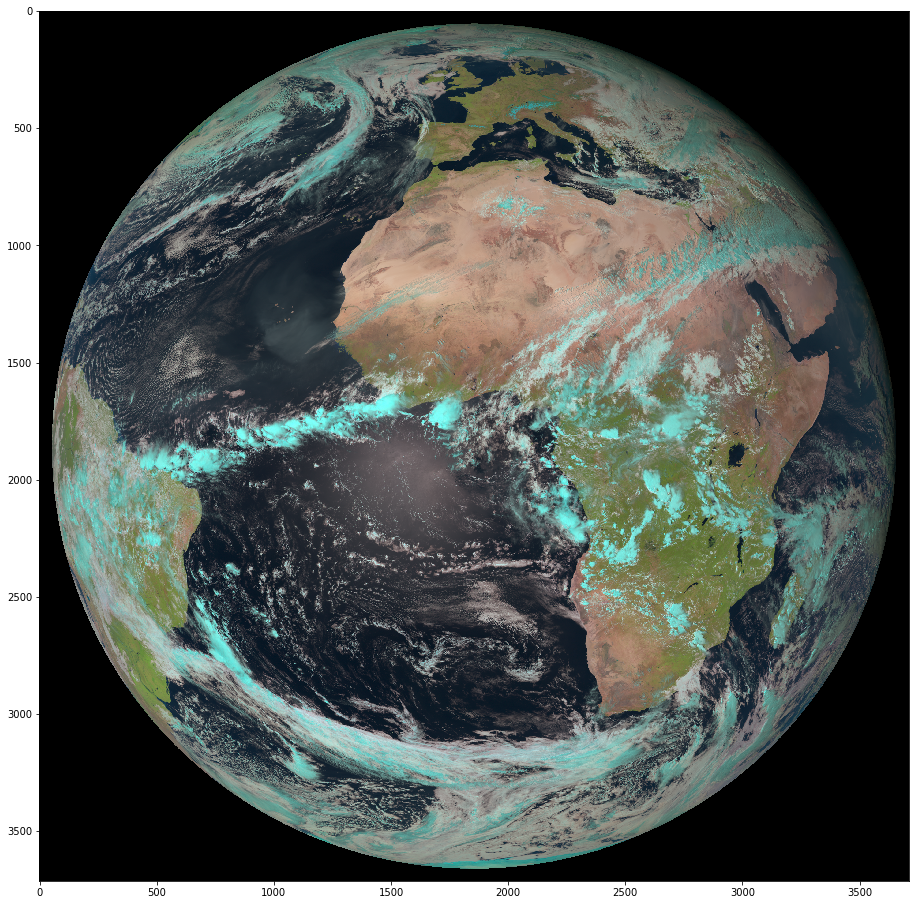

In [102]:
fig,ax = plt.subplots(1,1,figsize=(16,16))
ax.imshow(nc)

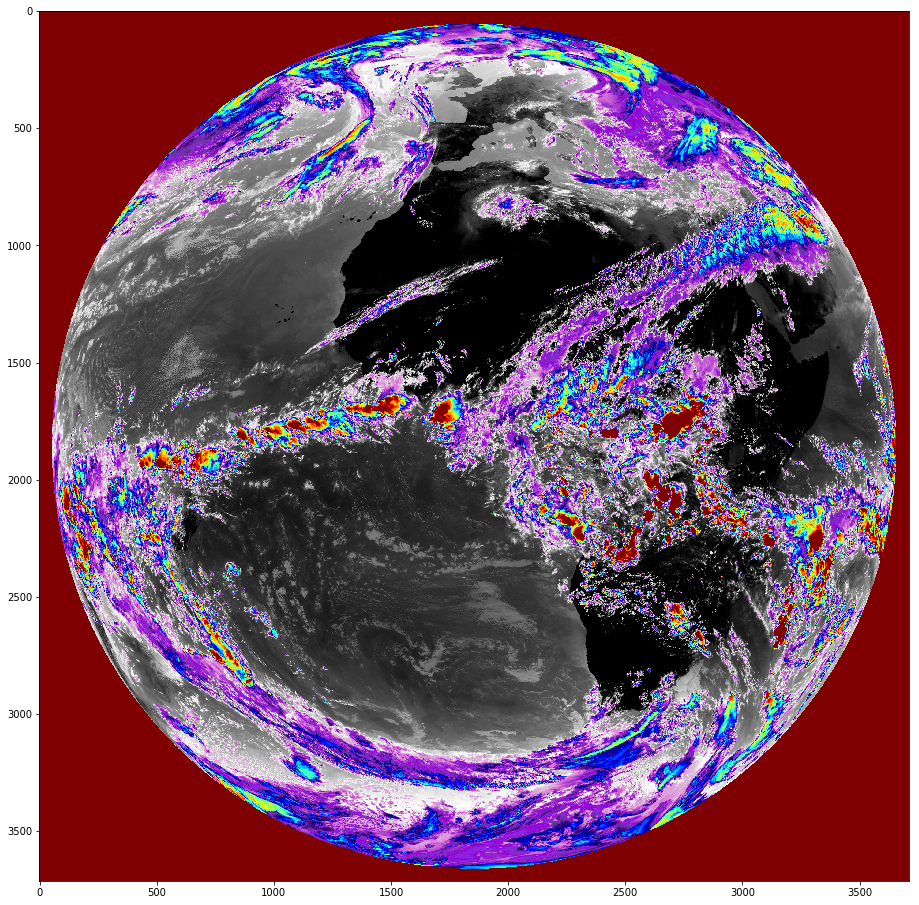

In [103]:
fig,ax = plt.subplots(1,1,figsize=(16,16))
ax.imshow(sat_data['IR_108'],vmin=210,vmax=300,cmap=emap)

Als nächstes ermitteln wir die Sonnenzenithwinkel für die aktuelle Szene.

In [104]:
pfad  = '/vols/talos/home/stephan/data/SEVIRI/auxdata/msevi-geolocation-{}.h5'.format(scan_type)
with h5py.File(pfad,'r') as hf:
    lon = hf.get('longitude')
    lat = hf.get('latitude')
    lon = np.array(lon)
    lat = np.array(lat)
jd = astro.dt2julday(latest_time_slot)
z = astro.zenith_azimuth(jd,lat,lon)

In [105]:
z

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32))

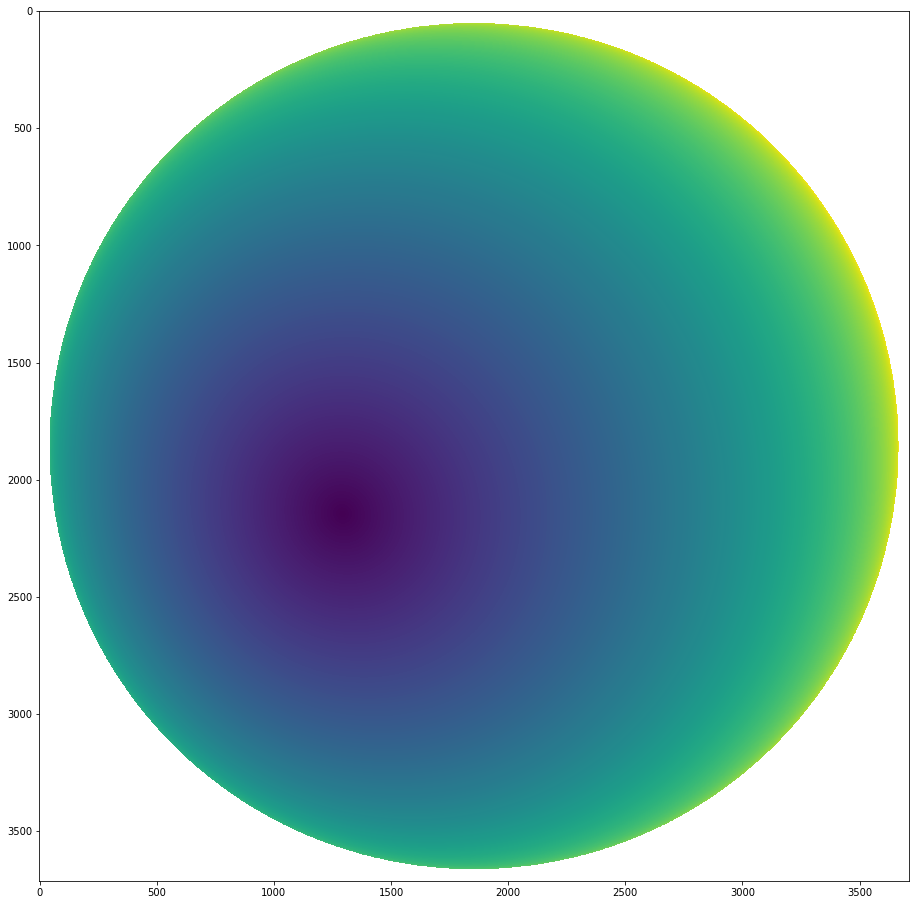

In [106]:
fig,ax = plt.subplots(1,1,figsize=(16,16))
ax.imshow(z[0])

Der Sonnenauf- und untergang ist bei einem Sonnenzenithwinkel von 90°. Deshalb maskieren wir alle Werte, wo der Winkel größer ist im NC-Komposit.

In [109]:
sunzen_masked = np.ma.masked_greater(z[0],90)

In [124]:
ir108_masked = np.ma.masked_where(z[0]<=90,sat_data['IR_108'])
ir108_masked = np.ma.masked_less_equal(ir108_masked,0)

/vols/talos/local/anaconda2-5.0.0/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.


In [125]:
ir108_masked

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

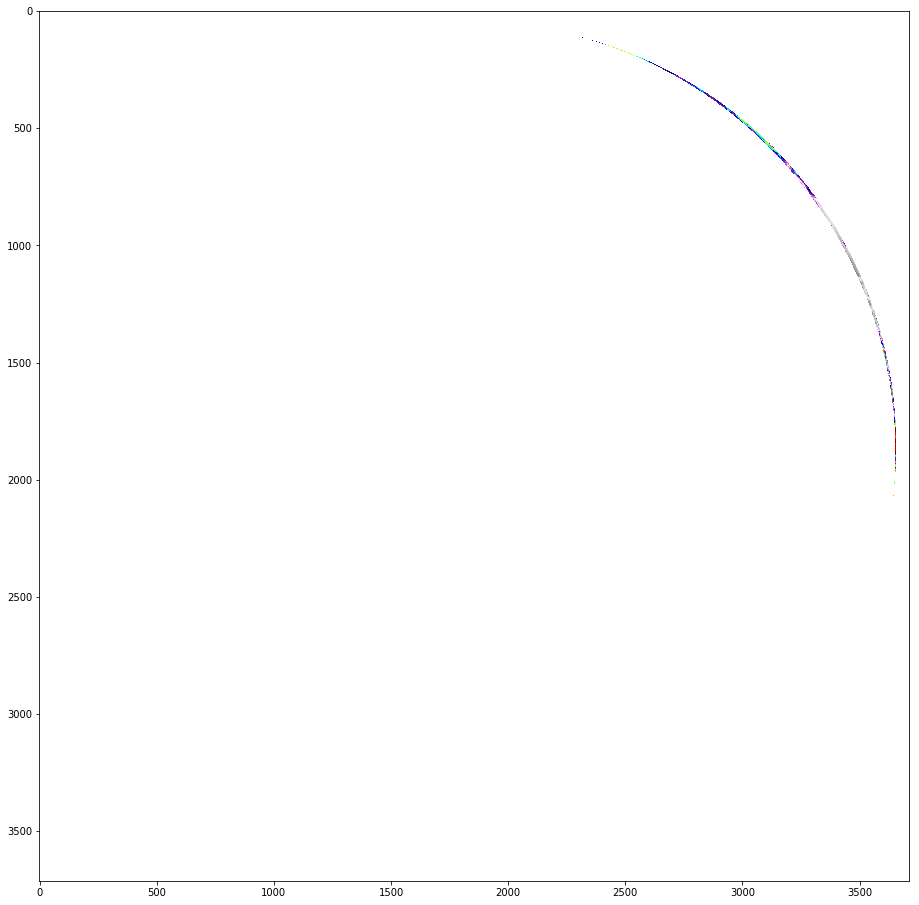

In [126]:
fig,ax = plt.subplots(1,1,figsize=(16,16))
ax.imshow(ir108_masked,vmin=210,vmax=300,cmap=emap)

Auf dem IR-Bild sind die Länder und Kontinente nicht so richtig zu erkennen. Deshalb erstellen wir uns eine Karte und Koordinatenlinien zum darüberlegen.

In [129]:
slon,slat = mst.get_msg_lon_lat('full',scan_type=scan_type)

In [ ]:
slon,slat = mst.get_msg_lon_lat

In [158]:
bmap_param = {
    'projection': 'geos',
    'rsphere': (6378169.0,6356583.8),
    'satellite_height': 35785831.0,
    'lon_0': 0.0,
    'lat_0': 0.0,
    'resolution':'l',
     'area_thresh':100000,
    'fix_aspect':False
}

mp = Basemap(**bmap_param)

In [132]:
x,y = mp(slon,slat)

In [149]:
def pcolormesh_nan(x, y, c, cmap=None, axis=None,**kwargs):
    """handles NaN in x and y by smearing last valid value in column or row out,
    which doesn't affect plot because "c" will be masked too
    """

    mask = np.isfinite(x) & np.isfinite(y)
    top = None

    for i, m in enumerate(mask):
        good = m.nonzero()[0]

        if good.size == 0:
            continue
        elif top is None:
            top = i
        else:
            bottom = i

        x[i, good[-1]:] = x[i, good[-1]]
        y[i, good[-1]:] = y[i, good[-1]]

        x[i, :good[0]] = x[i, good[0]]
        y[i, :good[0]] = y[i, good[0]]

    x[:top, :] = np.nanmax(x[top, :])
    y[:top, :] = np.nanmax(y[top, :])

    x[bottom:, :] = np.nanmax(x[bottom, :])
    y[bottom:, :] = np.nanmax(y[bottom, :])

    if axis is None:
        axis = plt.figure().gca()

    axis.pcolormesh(x, y, np.ma.masked_where(~mask, c), cmap=cmap,**kwargs)

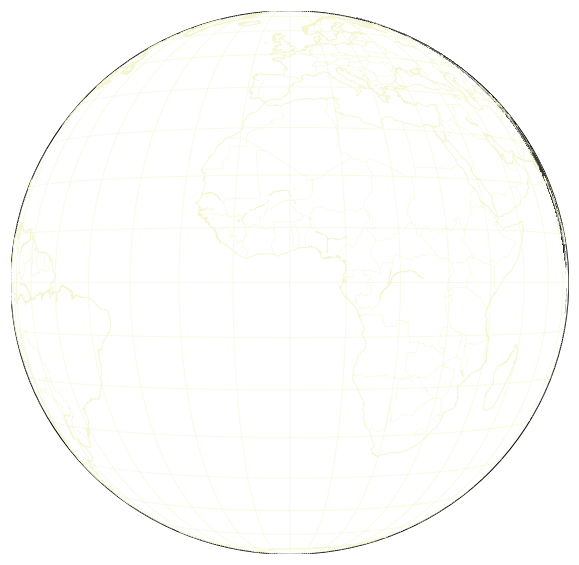

In [163]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.gca()
pcolormesh_nan(np.ma.masked_where(x==1e30,x),np.ma.masked_where(y==1e30,y),
               np.ma.masked_invalid(ir108_masked),vmin=210,vmax=300,cmap='gray_r',axis=ax)
mp.drawcoastlines(linewidth=0.8,color='#F5F6CE')
mp.drawcountries(linewidth=0.4,color='#f5f6ce')
mp.drawparallels(np.arange(-80.,90.,10.),color='#F5F6CE')
mp.drawmeridians(np.arange(-80.,90.,10.),color='#F5F6CE')
plt.savefig("/vols/talos/home/stephan/pics/latest_ir.png")

In [164]:
nc_image = PIL.Image.fromarray(nc)
ir_imag = PIL.Image.open("/vols/talos/home/stephan/pics/latest_ir.png")

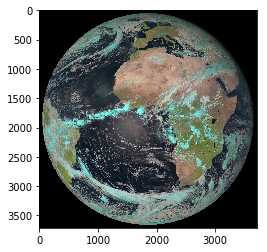

In [160]:
plt.imshow(nc_image)

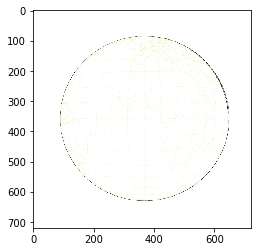

In [165]:
plt.imshow(ir_imag)